# Sentiment Analysis con KNN
## Clasificador en C++ 💪💪
Vamos a probar a nuestro bichito


Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [1]:
!cd .. && git submodule init
!cd .. && git submodule update
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: build: File exists
-- The C compiler identification is AppleClang 10.0.0.10001145
-- The CXX compiler identification is AppleClang 10.0.0.10001145
-- Check for working C compiler: /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/cc
-- Check for working C compiler: /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/c++
-- Check for working CXX compiler: /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp

In [2]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import sentiment


/Users/vpomsztein/Documents/PrivateRepositories/SentimentAnalysisMetNum/notebooks
Python 3.6.5 :: Anaconda, Inc.


In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd

!cd ../data && tar -xvf *.tgz

df = pd.read_csv("../data/imdb_small.csv", index_col=0)

print("Cantidad de documentos: {}".format(df.shape[0]))

x ./._imdb_small.csv
x imdb_small.csv
Cantidad de documentos: 12500


In [4]:
df.describe()

,type,review,label,file
count,12500,12500,12500,12500
unique,2,12469,2,12085
top,test,This show comes up with interesting locations ...,neg,5609_10.txt
freq,6275,2,6322,2


In [5]:
text_train = df[df.type == 'train']["review"]
label_train = df[df.type == 'train']["label"]

text_test = df[df.type == 'test']["review"]
label_test = df[df.type == 'test']["label"]

print("Cantidad de instancias de entrenamiento = {}".format(len(text_train)))
print("Cantidad de instancias de test = {}".format(len(text_test)))



Cantidad de instancias de entrenamiento = 6225
Cantidad de instancias de test = 6275


In [6]:
from __future__ import division
print("Class balance : {} pos {} neg".format(
    (label_train == 'pos').sum() / label_train.shape[0], 
    (label_train == 'neg').sum() / label_train.shape[0]
))


Class balance : 0.49493975903614457 pos 0.5050602409638554 neg


In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.90, min_df=0.01, max_features=5000)

vectorizer.fit(text_train)

X_train, y_train = vectorizer.transform(text_train), (label_train == 'pos').values
X_test, y_test = vectorizer.transform(text_test), (label_test == 'pos').values

In [8]:
import sentiment
import numpy as np
import matplotlib.pyplot as plt

In [9]:
import calendar;
import time;

def f1score(acc, prec, rec):
    f1 = 2*(prec*rec)/(prec+rec)
    return f1

def getMetrics(predictions, actualValues):
    tp = np.sum( np.logical_and(predictions == 1, actualValues == 1) )
    tn = np.sum( np.logical_and(predictions == 0, actualValues == 0) )
    fp = np.sum( np.logical_and(predictions == 1, actualValues == 0) )
    fn = np.sum( np.logical_and(predictions == 0, actualValues == 1) )

    acc = (tp + tn) / (tp+tn+fp+fn)
    if (tp + fp) == 0:
        prec = 0
    else:
        prec = tp / (tp + fp)
    if (tp + fn) == 0:
        rec = 0
    else:
        rec = tp / (tp + fn)
    return acc, prec, rec

def saveData(filename, data):
    ts = calendar.timegm(time.gmtime())
    np.savetxt("{}_{}.csv".format(ts, filename), data, delimiter=",")
    
print("Done! You're a good boy 🐶")

Done! You're a good boy 🐶


In [ ]:
%%time

# Esta celda puede ser ejecutada sólo cuando se quiere probar PCA
pca = sentiment.PCA(50)
pca.fit(X_train)

In [ ]:

# Idem anterior!

pca_x_train = pca.transform(X_train)
pca_x_test = pca.transform(X_test)

In [ ]:
%%time

# Descomentar la implementación deseada:
# Uncomment this for KNN only (PCA disabled):
# clf = sentiment.KNNClassifier(100)
# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test[:500])
# acc = accuracy_score(y_test[:500], y_pred[:500])

# Uncomment this for PCA enabled:
clf = sentiment.KNNClassifier(550)
clf.fit(pca_x_train, y_train)

y_pred = clf.predict(pca_x_test)

acc, prec, rec = getMetrics(y_pred, y_test)

print(acc, prec, rec)

In [ ]:
## ==================== Experimento 1 ========================
## Análisis de calidad de resultados en base a k y alpha

## Analizo la variación de las métricas en funcion de k

K_vals = np.arange(0,500,25)
K_vals[0] = 1
mets = np.zeros((len(K_vals), 3))
               
for i,a in enumerate(K_vals):
    pca = sentiment.PCA(a)
    pca.fit(X_train[:1000])
    Xtc_train = pca.transform(X_train[:1000])
    Xtc_test = pca.transform(X_test[:1000])
    
    clf = sentiment.KNNClassifier(25)
    clf.fit(Xtc_train, y_train[:1000])
    preds = clf.predict(Xtc_test)
    acc, prec, rec = getMetrics(preds[:1000], y_test[:1000])
    mets[i] = [acc, prec, rec]
    print("Finished {}".format(a))
    
plt.plot(K_vals,mets[:,0], 'b.-')
plt.plot(K_vals,mets[:,1], 'r.-')
plt.plot(K_vals,mets[:,2], 'g.-')
plt.title("Metricas en funcion de Alpha")
plt.xlabel("K")
plt.ylabel("%")
plt.axis([1, K_vals[-1], 0.4, 1])
plt.gca().legend(('Acc','Prec','Recall'))

Finished 1
Finished 25
Finished 50
Finished 75
Finished 100
Finished 125


In [ ]:
## Analizo la variación de las métricas en funcion de alpha para K fijo

alphas = np.arange(0,500,50)
alphas[0] = 1
K_vals_fixes = np.array([50,550,1100])

dmets = { i : np.zeros((len(alphas), 3)) for i in K_vals_fixes}
dmets

In [ ]:
print("Beginning alpha metric calculations")

for i,a in enumerate(alphas):
    
    pca = sentiment.PCA(a)
    pca.fit(X_train)
    Xtc_train = pca.transform(X_train)
    Xtc_test = pca.transform(X_test)
    print("Finished training PCA {}".format(a))

    for j, k in enumerate(K_vals_fixes):
        clf = sentiment.KNNClassifier(k)
        clf.fit(Xtc_train, y_train)
        preds = clf.predict(Xtc_test)
        acc, prec, rec = getMetrics(preds, y_test)
        mets = dmets[k]
        mets[i] = [acc, prec, rec]
        print("Finished {}, alpha = {}".format(k, a))


## Metricas para PCA:

line_styles = ['b.-', 'r.-', 'g.-', 'k.-', 'y.-', 'm.-']
for j,k in enumerate(K_vals_fixes):
    mets = dmets[k]

    plt.subplot(3, 1, 1)
    plt.plot(alphas,mets[:,0], line_styles[j])
    plt.ylabel("Acc")
    plt.xticks([])

    plt.subplot(3, 1, 2)
    plt.plot(alphas,mets[:,1], line_styles[j])
    plt.ylabel("Prec")
    plt.xticks([])
    
    plt.subplot(3, 1, 3)
    plt.plot(alphas,mets[:,2], line_styles[j])
    plt.ylabel("Rec")
    plt.xticks([])

    
plt.xlabel("alpha")
plt.xticks(alphas)
plt.axis([1, alphas[-1], 0.3, 0.8])
plt.gca().legend([str(i) for i in K_vals_fixes])

In [ ]:
a = np.random.random((1200, 500))

# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-1, 1200), np.linspace(1, 500))

z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z_min, z_max = -np.abs(z).max(), np.abs(z).max()

fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

# plt.show()

# plt.imshow(a, cmap='hot', interpolation='nearest')
# plt.show()
dmets
y

In [ ]:
for i in range(15, 0, -1): # <--Delete me
    print(i)
    pca = sentiment.PCA(min(i, 50))
    pca.fit(X_train[:i])
    Xtc_train = pca.transform(X_train[:i])
    Ytc_train = y_train[:i]
    Xtc_test = pca.transform(X_test)
    
    for k in range(min(i, 50), 0, -1): # <--Delete me
        clf = sentiment.KNNClassifier(k)

Will have 52 trainSize instances
Will have 50 knn instances
Finished training PCA train_size = 6225
Finished k = 2500, train_size = 6225
Finished k = 2450, train_size = 6225
Finished k = 2400, train_size = 6225
Finished k = 2350, train_size = 6225
Finished k = 2300, train_size = 6225
Finished k = 2250, train_size = 6225
Finished k = 2200, train_size = 6225
Finished k = 2150, train_size = 6225
Finished k = 2100, train_size = 6225
Finished k = 2050, train_size = 6225
Finished k = 2000, train_size = 6225
Finished k = 1950, train_size = 6225
Finished k = 1900, train_size = 6225
Finished k = 1850, train_size = 6225
Finished k = 1800, train_size = 6225
Finished k = 1750, train_size = 6225
Finished k = 1700, train_size = 6225
Finished k = 1650, train_size = 6225
Finished k = 1600, train_size = 6225
Finished k = 1550, train_size = 6225
Finished k = 1500, train_size = 6225
Finished k = 1450, train_size = 6225
Finished k = 1400, train_size = 6225
Finished k = 1350, train_size = 6225
Finished k =

Finished k = 1650, train_size = 5745
Finished k = 1600, train_size = 5745
Finished k = 1550, train_size = 5745
Finished k = 1500, train_size = 5745
Finished k = 1450, train_size = 5745
Finished k = 1400, train_size = 5745
Finished k = 1350, train_size = 5745
Finished k = 1300, train_size = 5745
Finished k = 1250, train_size = 5745
Finished k = 1200, train_size = 5745
Finished k = 1150, train_size = 5745
Finished k = 1100, train_size = 5745
Finished k = 1050, train_size = 5745
Finished k = 1000, train_size = 5745
Finished k = 950, train_size = 5745
Finished k = 900, train_size = 5745
Finished k = 850, train_size = 5745
Finished k = 800, train_size = 5745
Finished k = 750, train_size = 5745
Finished k = 700, train_size = 5745
Finished k = 650, train_size = 5745
Finished k = 600, train_size = 5745
Finished k = 550, train_size = 5745
Finished k = 500, train_size = 5745
Finished k = 450, train_size = 5745
Finished k = 400, train_size = 5745
Finished k = 350, train_size = 5745
Finished k = 3

Finished k = 650, train_size = 5265
Finished k = 600, train_size = 5265
Finished k = 550, train_size = 5265
Finished k = 500, train_size = 5265
Finished k = 450, train_size = 5265
Finished k = 400, train_size = 5265
Finished k = 350, train_size = 5265
Finished k = 300, train_size = 5265
Finished k = 250, train_size = 5265
Finished k = 200, train_size = 5265
Finished k = 150, train_size = 5265
Finished k = 100, train_size = 5265
Finished k = 50, train_size = 5265
Finished training PCA train_size = 5145
Finished k = 2500, train_size = 5145
Finished k = 2450, train_size = 5145
Finished k = 2400, train_size = 5145
Finished k = 2350, train_size = 5145
Finished k = 2300, train_size = 5145
Finished k = 2250, train_size = 5145
Finished k = 2200, train_size = 5145
Finished k = 2150, train_size = 5145
Finished k = 2100, train_size = 5145
Finished k = 2050, train_size = 5145
Finished k = 2000, train_size = 5145
Finished k = 1950, train_size = 5145
Finished k = 1900, train_size = 5145
Finished k =

Finished k = 2200, train_size = 4665
Finished k = 2150, train_size = 4665
Finished k = 2100, train_size = 4665
Finished k = 2050, train_size = 4665
Finished k = 2000, train_size = 4665
Finished k = 1950, train_size = 4665
Finished k = 1900, train_size = 4665
Finished k = 1850, train_size = 4665
Finished k = 1800, train_size = 4665
Finished k = 1750, train_size = 4665
Finished k = 1700, train_size = 4665
Finished k = 1650, train_size = 4665
Finished k = 1600, train_size = 4665
Finished k = 1550, train_size = 4665
Finished k = 1500, train_size = 4665
Finished k = 1450, train_size = 4665
Finished k = 1400, train_size = 4665
Finished k = 1350, train_size = 4665
Finished k = 1300, train_size = 4665
Finished k = 1250, train_size = 4665
Finished k = 1200, train_size = 4665
Finished k = 1150, train_size = 4665
Finished k = 1100, train_size = 4665
Finished k = 1050, train_size = 4665
Finished k = 1000, train_size = 4665
Finished k = 950, train_size = 4665
Finished k = 900, train_size = 4665
Fin

Finished k = 1200, train_size = 4185
Finished k = 1150, train_size = 4185
Finished k = 1100, train_size = 4185
Finished k = 1050, train_size = 4185
Finished k = 1000, train_size = 4185
Finished k = 950, train_size = 4185
Finished k = 900, train_size = 4185
Finished k = 850, train_size = 4185
Finished k = 800, train_size = 4185
Finished k = 750, train_size = 4185
Finished k = 700, train_size = 4185
Finished k = 650, train_size = 4185
Finished k = 600, train_size = 4185
Finished k = 550, train_size = 4185
Finished k = 500, train_size = 4185
Finished k = 450, train_size = 4185
Finished k = 400, train_size = 4185
Finished k = 350, train_size = 4185
Finished k = 300, train_size = 4185
Finished k = 250, train_size = 4185
Finished k = 200, train_size = 4185
Finished k = 150, train_size = 4185
Finished k = 100, train_size = 4185
Finished k = 50, train_size = 4185
Finished training PCA train_size = 4065
Finished k = 2500, train_size = 4065
Finished k = 2450, train_size = 4065
Finished k = 2400,

Finished k = 200, train_size = 3705
Finished k = 150, train_size = 3705
Finished k = 100, train_size = 3705
Finished k = 50, train_size = 3705
Finished training PCA train_size = 3585
Finished k = 2500, train_size = 3585
Finished k = 2450, train_size = 3585
Finished k = 2400, train_size = 3585
Finished k = 2350, train_size = 3585
Finished k = 2300, train_size = 3585
Finished k = 2250, train_size = 3585
Finished k = 2200, train_size = 3585
Finished k = 2150, train_size = 3585
Finished k = 2100, train_size = 3585
Finished k = 2050, train_size = 3585
Finished k = 2000, train_size = 3585
Finished k = 1950, train_size = 3585
Finished k = 1900, train_size = 3585
Finished k = 1850, train_size = 3585
Finished k = 1800, train_size = 3585
Finished k = 1750, train_size = 3585
Finished k = 1700, train_size = 3585
Finished k = 1650, train_size = 3585
Finished k = 1600, train_size = 3585
Finished k = 1550, train_size = 3585
Finished k = 1500, train_size = 3585
Finished k = 1450, train_size = 3585
Fin

Finished k = 1750, train_size = 3105
Finished k = 1700, train_size = 3105
Finished k = 1650, train_size = 3105
Finished k = 1600, train_size = 3105
Finished k = 1550, train_size = 3105
Finished k = 1500, train_size = 3105
Finished k = 1450, train_size = 3105
Finished k = 1400, train_size = 3105
Finished k = 1350, train_size = 3105
Finished k = 1300, train_size = 3105
Finished k = 1250, train_size = 3105
Finished k = 1200, train_size = 3105
Finished k = 1150, train_size = 3105
Finished k = 1100, train_size = 3105
Finished k = 1050, train_size = 3105
Finished k = 1000, train_size = 3105
Finished k = 950, train_size = 3105
Finished k = 900, train_size = 3105
Finished k = 850, train_size = 3105
Finished k = 800, train_size = 3105
Finished k = 750, train_size = 3105
Finished k = 700, train_size = 3105
Finished k = 650, train_size = 3105
Finished k = 600, train_size = 3105
Finished k = 550, train_size = 3105
Finished k = 500, train_size = 3105
Finished k = 450, train_size = 3105
Finished k =

Finished k = 750, train_size = 2625
Finished k = 700, train_size = 2625
Finished k = 650, train_size = 2625
Finished k = 600, train_size = 2625
Finished k = 550, train_size = 2625
Finished k = 500, train_size = 2625
Finished k = 450, train_size = 2625
Finished k = 400, train_size = 2625
Finished k = 350, train_size = 2625
Finished k = 300, train_size = 2625
Finished k = 250, train_size = 2625
Finished k = 200, train_size = 2625
Finished k = 150, train_size = 2625
Finished k = 100, train_size = 2625
Finished k = 50, train_size = 2625
Finished training PCA train_size = 2505
Finished k = 2500, train_size = 2505
Finished k = 2450, train_size = 2505
Finished k = 2400, train_size = 2505
Finished k = 2350, train_size = 2505
Finished k = 2300, train_size = 2505
Finished k = 2250, train_size = 2505
Finished k = 2200, train_size = 2505
Finished k = 2150, train_size = 2505
Finished k = 2100, train_size = 2505
Finished k = 2050, train_size = 2505
Finished k = 2000, train_size = 2505
Finished k = 1

Finished k = 1000, train_size = 2025
Finished k = 950, train_size = 2025
Finished k = 900, train_size = 2025
Finished k = 850, train_size = 2025
Finished k = 800, train_size = 2025
Finished k = 750, train_size = 2025
Finished k = 700, train_size = 2025
Finished k = 650, train_size = 2025
Finished k = 600, train_size = 2025
Finished k = 550, train_size = 2025
Finished k = 500, train_size = 2025
Finished k = 450, train_size = 2025
Finished k = 400, train_size = 2025
Finished k = 350, train_size = 2025
Finished k = 300, train_size = 2025
Finished k = 250, train_size = 2025
Finished k = 200, train_size = 2025
Finished k = 150, train_size = 2025
Finished k = 100, train_size = 2025
Finished k = 50, train_size = 2025
Finished training PCA train_size = 1905
Finished k = 1900, train_size = 1905
Finished k = 1850, train_size = 1905
Finished k = 1800, train_size = 1905
Finished k = 1750, train_size = 1905
Finished k = 1700, train_size = 1905
Finished k = 1650, train_size = 1905
Finished k = 1600,

Finished k = 750, train_size = 1185
Finished k = 700, train_size = 1185
Finished k = 650, train_size = 1185
Finished k = 600, train_size = 1185
Finished k = 550, train_size = 1185
Finished k = 500, train_size = 1185
Finished k = 450, train_size = 1185
Finished k = 400, train_size = 1185
Finished k = 350, train_size = 1185
Finished k = 300, train_size = 1185
Finished k = 250, train_size = 1185
Finished k = 200, train_size = 1185
Finished k = 150, train_size = 1185
Finished k = 100, train_size = 1185
Finished k = 50, train_size = 1185
Finished training PCA train_size = 1065
Finished k = 1050, train_size = 1065
Finished k = 1000, train_size = 1065
Finished k = 950, train_size = 1065
Finished k = 900, train_size = 1065
Finished k = 850, train_size = 1065
Finished k = 800, train_size = 1065
Finished k = 750, train_size = 1065
Finished k = 700, train_size = 1065
Finished k = 650, train_size = 1065
Finished k = 600, train_size = 1065
Finished k = 550, train_size = 1065
Finished k = 500, train

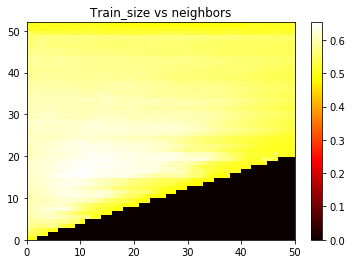

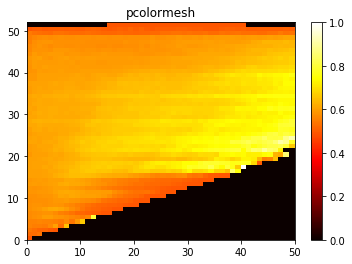

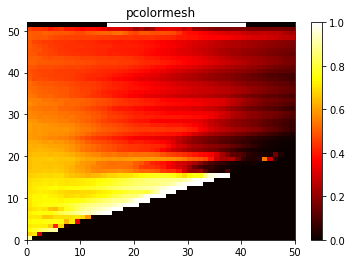

In [10]:
trainSizeRange = range(X_train.shape[0], 0, -120)
trainSizeRangeLength = len(trainSizeRange)
knnRange = range(2500, 0, -50)
knnRangeLength = len(knnRange)

print("Will have {} trainSize instances".format(trainSizeRangeLength))
print("Will have {} knn instances".format(knnRangeLength))

accColorMap = np.zeros(shape=(trainSizeRangeLength, len(knnRange)))
precColorMap = np.zeros(shape=(trainSizeRangeLength, len(knnRange)))
recColorMap = np.zeros(shape=(trainSizeRangeLength, len(knnRange)))

for i in range(0, len(trainSizeRange)):
    trainSize = trainSizeRange[i]
    pca = sentiment.PCA(min(i, 50))
    pca.fit(X_train[:trainSize])
    Xtc_train = pca.transform(X_train[:trainSize])
    Ytc_train = y_train[:trainSize]
    Xtc_test = pca.transform(X_test)
    print("Finished training PCA train_size = {}".format(trainSize))

    for j in range(0, knnRangeLength):
        k = knnRange[j]
        if (k <= trainSize):
            clf = sentiment.KNNClassifier(k)
            clf.fit(Xtc_train, Ytc_train)
            preds = clf.predict(Xtc_test)
            acc, prec, rec = getMetrics(preds, y_test)
            accColorMap[trainSizeRangeLength - i - 1, knnRangeLength - j - 1] = acc
            precColorMap[trainSizeRangeLength - i - 1, knnRangeLength - j - 1] = prec
            recColorMap[trainSizeRangeLength - i - 1, knnRangeLength - j - 1] = rec
            print("Finished k = {}, train_size = {}".format(k, trainSize))
        else:
            accColorMap[trainSizeRangeLength - i - 1, knnRangeLength - j - 1] = 0
            precColorMap[trainSizeRangeLength - i - 1, knnRangeLength - j - 1] = 0
            recColorMap[trainSizeRangeLength - i - 1, knnRangeLength - j - 1] = 0

saveData("accColorMap", accColorMap)
saveData("precColorMap", precColorMap)
saveData("recColorMap", recColorMap)
        
fig, ax = plt.subplots()

c = ax.pcolormesh(accColorMap, cmap='hot')
ax.set_title('Train_size vs neighbors')
# set the limits of the plot to the limits of the data
ax.axis([0, accColorMap.shape[1], 0, accColorMap.shape[0]])
fig.colorbar(c, ax=ax)

fig2, ax2 = plt.subplots()

c2 = ax2.pcolormesh(precColorMap, cmap='hot')
ax2.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax2.axis([0, precColorMap.shape[1], 0, precColorMap.shape[0]])
fig2.colorbar(c2, ax=ax2)

fig3, ax3 = plt.subplots()

c3 = ax3.pcolormesh(recColorMap, cmap='hot')
ax3.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax3.axis([0, recColorMap.shape[1], 0, recColorMap.shape[0]])
fig3.colorbar(c3, ax=ax3)

plt.show()

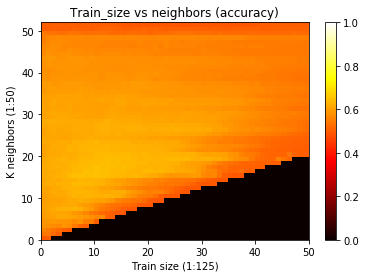

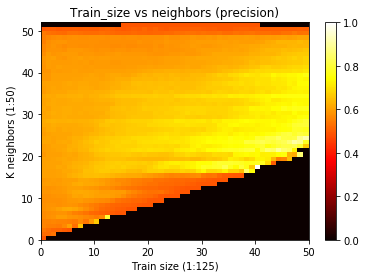

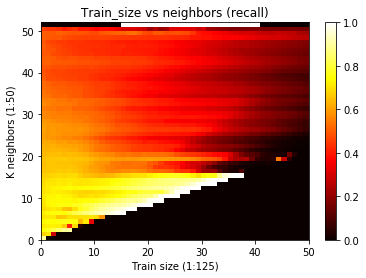

In [26]:
fig, ax = plt.subplots()

c = ax.pcolormesh(accColorMap, cmap='hot', vmin=0, vmax=1)
ax.set_title('Train_size vs neighbors (accuracy)')
# set the limits of the plot to the limits of the data
ax.axis([0, accColorMap.shape[1], 0, accColorMap.shape[0]])
ax.set_xlabel("Train size (1:125)")
ax.set_ylabel("K neighbors (1:50)")
fig.colorbar(c, ax=ax)

fig2, ax2 = plt.subplots()

c2 = ax2.pcolormesh(precColorMap, cmap='hot', vmin=0, vmax=1)
ax2.set_title('Train_size vs neighbors (precision)')
# set the limits of the plot to the limits of the data
ax2.axis([0, precColorMap.shape[1], 0, precColorMap.shape[0]])
ax2.set_xlabel("Train size (1:125)")
ax2.set_ylabel("K neighbors (1:50)")
fig2.colorbar(c2, ax=ax2)

fig3, ax3 = plt.subplots()

c3 = ax3.pcolormesh(recColorMap, cmap='hot', vmin=0, vmax=1)
ax3.set_title('Train_size vs neighbors (recall)')
# set the limits of the plot to the limits of the data
ax3.axis([0, recColorMap.shape[1], 0, recColorMap.shape[0]])
ax3.set_xlabel("Train size (1:125)")
ax3.set_ylabel("K neighbors (1:50)")
fig3.colorbar(c3, ax=ax3)

plt.show()